# **Linear Regression: Predictive Modeling**

A comprehensive exploration of linear regression techniques including Simple, Multiple, Polynomial, Ridge, and Lasso regression with full diagnostic analysis on the Diabetes dataset.

In [1]:
# --- Import Libraries ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

print("Libraries loaded successfully!")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

Libraries loaded successfully!
NumPy: 2.4.2
Pandas: 3.0.0


In [2]:
# --- Load Diabetes Dataset ---
print("=" * 60)
print("DATASET: DIABETES")
print("=" * 60)

diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name='Progression')

print(f"\nSamples: {X.shape[0]:,}")
print(f"Features: {X.shape[1]}")
print(f"Feature Names: {list(diabetes.feature_names)}")
print(f"Target: Disease progression one year after baseline")
print(f"\nTarget Range: {y.min():.1f} - {y.max():.1f}")
print(f"Target Mean:  {y.mean():.1f}")

DATASET: DIABETES

Samples: 442
Features: 10
Feature Names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Target: Disease progression one year after baseline

Target Range: 25.0 - 346.0
Target Mean:  152.1


DATA EXPLORATION

First 5 Rows:
        age       sex       bmi        bp        s1        s2        s3        s4        s5        s6  Progression
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401 -0.002592  0.019907 -0.017646        151.0
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412 -0.039493 -0.068332 -0.092204         75.0
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356 -0.002592  0.002861 -0.025930        141.0
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038  0.034309  0.022688 -0.009362        206.0
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142 -0.002592 -0.031988 -0.046641        135.0

DESCRIPTIVE STATISTICS
           age      sex      bmi       bp       s1       s2       s3       s4       s5       s6  Progression
count  442.000  442.000  442.000  442.000  442.000  442.000  442.000  442.000  442.000  442.000      442.000
mean    -0.000    0.000   -0.000   -

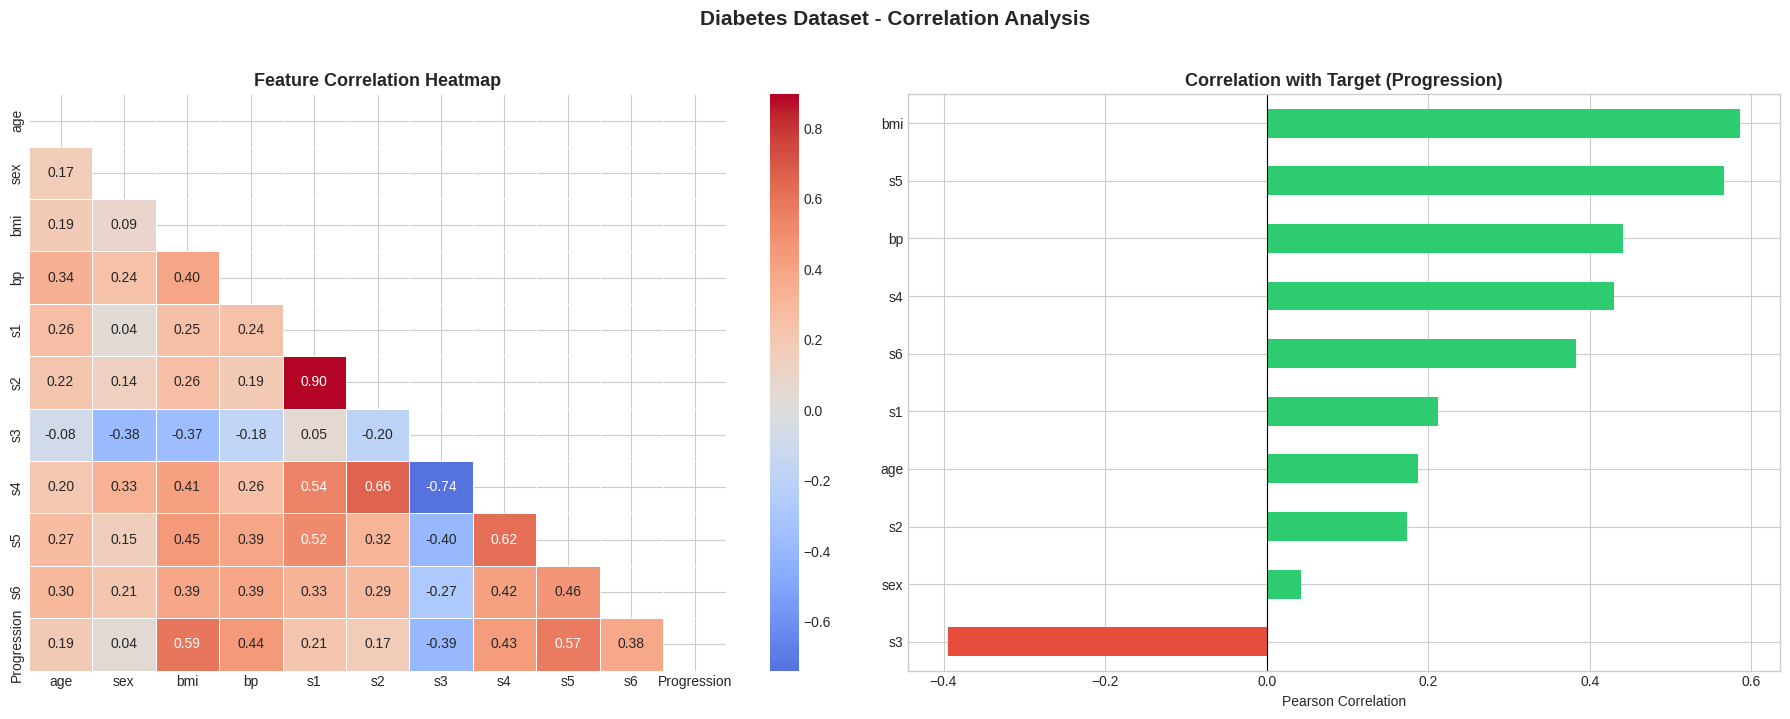


Top Correlated Features with Target:
  bmi            : +0.5865
  s5             : +0.5659
  bp             : +0.4415
  s4             : +0.4305
  s6             : +0.3825
  s1             : +0.2120
  age            : +0.1879
  s2             : +0.1741
  sex            : +0.0431
  s3             : -0.3948


In [3]:
# --- Explore Dataset ---
print("=" * 60)
print("DATA EXPLORATION")
print("=" * 60)

df = X.copy()
df['Progression'] = y

print("\nFirst 5 Rows:")
print(df.head().to_string())

print("\n" + "=" * 60)
print("DESCRIPTIVE STATISTICS")
print("=" * 60)
print(df.describe().round(3).to_string())

print(f"\nMissing Values: {df.isnull().sum().sum()}")

# Correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, ax=axes[0])
axes[0].set_title('Feature Correlation Heatmap', fontsize=13, fontweight='bold')

# Target correlation
target_corr = corr['Progression'].drop('Progression').sort_values(ascending=True)
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in target_corr]
target_corr.plot(kind='barh', color=colors, ax=axes[1])
axes[1].set_title('Correlation with Target (Progression)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Pearson Correlation')
axes[1].axvline(x=0, color='black', linewidth=0.8)

plt.suptitle('Diabetes Dataset - Correlation Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nTop Correlated Features with Target:")
for feat, val in target_corr.sort_values(ascending=False).items():
    print(f"  {feat:15s}: {val:+.4f}")

DATA PREPROCESSING

Training Set:  353 samples
Test Set:      89 samples

Scaling: StandardScaler applied
  Mean (train, post-scaling): -0.000000
  Std  (train, post-scaling): 1.0014


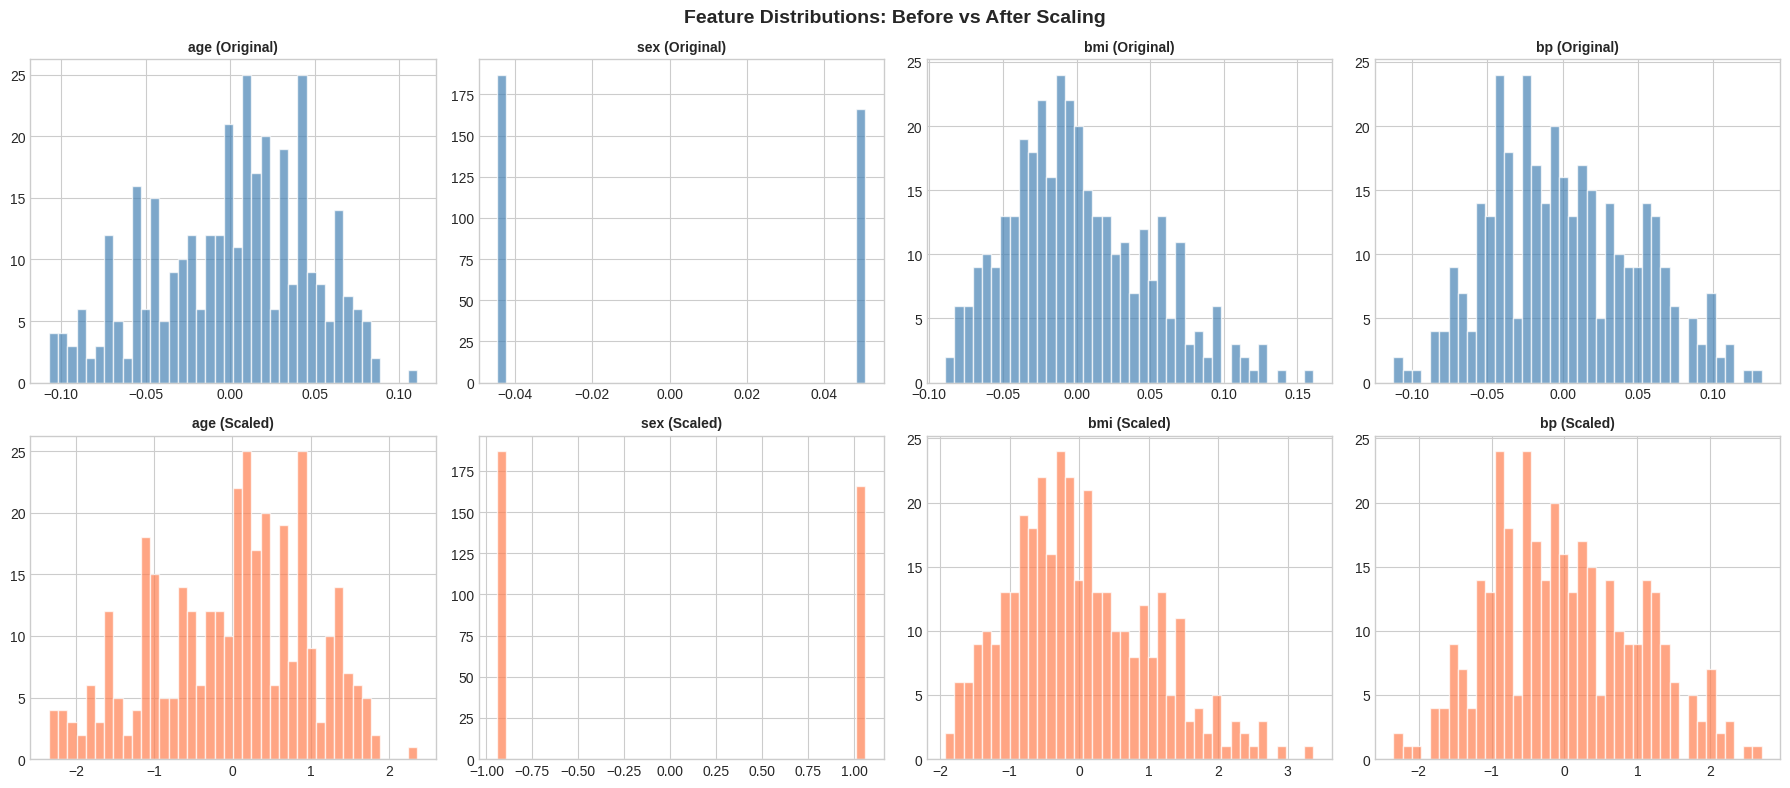

In [4]:
# --- Data Preprocessing ---
print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining Set:  {X_train.shape[0]:,} samples")
print(f"Test Set:      {X_test.shape[0]:,} samples")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"\nScaling: StandardScaler applied")
print(f"  Mean (train, post-scaling): {X_train_scaled.mean().mean():.6f}")
print(f"  Std  (train, post-scaling): {X_train_scaled.std().mean():.4f}")

# Show feature distributions before and after scaling
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
for i, col in enumerate(X.columns[:4]):
    axes[0, i].hist(X_train[col], bins=40, color='steelblue', alpha=0.7, edgecolor='white')
    axes[0, i].set_title(f'{col} (Original)', fontsize=10, fontweight='bold')
    axes[1, i].hist(X_train_scaled[col], bins=40, color='coral', alpha=0.7, edgecolor='white')
    axes[1, i].set_title(f'{col} (Scaled)', fontsize=10, fontweight='bold')

plt.suptitle('Feature Distributions: Before vs After Scaling', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
# --- Simple Linear Regression ---
print("=" * 60)
print("SIMPLE LINEAR REGRESSION (bmi -> Progression)")
print("=" * 60)

# Use bmi (Body Mass Index) - strong correlation with target
feature_name = 'bmi'
X_train_simple = X_train_scaled[[feature_name]].values
X_test_simple = X_test_scaled[[feature_name]].values

simple_lr = LinearRegression()
simple_lr.fit(X_train_simple, y_train)

y_pred_simple_train = simple_lr.predict(X_train_simple)
y_pred_simple_test = simple_lr.predict(X_test_simple)

print(f"\nFeature: {feature_name}")
print(f"Coefficient: {simple_lr.coef_[0]:.4f}")
print(f"Intercept:   {simple_lr.intercept_:.4f}")
print(f"\nTraining R²: {r2_score(y_train, y_pred_simple_train):.4f}")
print(f"Test R²:     {r2_score(y_test, y_pred_simple_test):.4f}")
print(f"Test MSE:    {mean_squared_error(y_test, y_pred_simple_test):.4f}")
print(f"Test MAE:    {mean_absolute_error(y_test, y_pred_simple_test):.4f}")
print(f"Test RMSE:   {np.sqrt(mean_squared_error(y_test, y_pred_simple_test)):.4f}")

SIMPLE LINEAR REGRESSION (bmi -> Progression)

Feature: bmi
Coefficient: 47.1411
Intercept:   153.7365

Training R²: 0.3657
Test R²:     0.2334
Test MSE:    4061.8259
Test MAE:    52.2600
Test RMSE:   63.7325


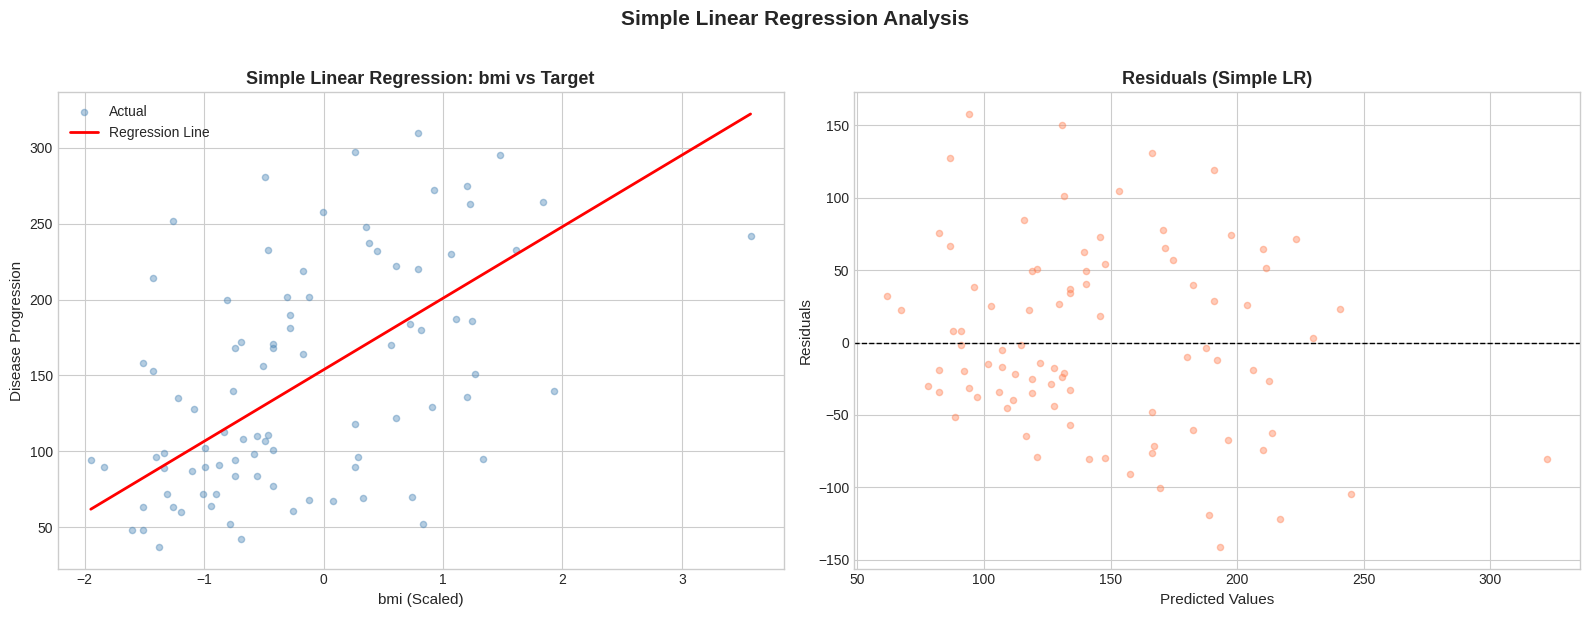

In [6]:
# --- Visualize Simple Regression ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot with regression line
sort_idx = X_test_simple.flatten().argsort()
axes[0].scatter(X_test_simple, y_test, alpha=0.4, s=20, color='steelblue', label='Actual')
axes[0].plot(X_test_simple[sort_idx], y_pred_simple_test[sort_idx],
             color='red', linewidth=2, label='Regression Line')
axes[0].set_xlabel(f'{feature_name} (Scaled)', fontsize=11)
axes[0].set_ylabel('Disease Progression', fontsize=11)
axes[0].set_title('Simple Linear Regression: bmi vs Target', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)

# Residuals for simple model
residuals_simple = y_test - y_pred_simple_test
axes[1].scatter(y_pred_simple_test, residuals_simple, alpha=0.4, s=20, color='coral')
axes[1].axhline(y=0, color='black', linewidth=1, linestyle='--')
axes[1].set_xlabel('Predicted Values', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title('Residuals (Simple LR)', fontsize=13, fontweight='bold')

plt.suptitle('Simple Linear Regression Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [7]:
# --- Multiple Linear Regression ---
print("=" * 60)
print("MULTIPLE LINEAR REGRESSION (All Features)")
print("=" * 60)

multi_lr = LinearRegression()
multi_lr.fit(X_train_scaled, y_train)

y_pred_multi_train = multi_lr.predict(X_train_scaled)
y_pred_multi_test = multi_lr.predict(X_test_scaled)

print(f"\nFeatures Used: {list(X.columns)}")
print(f"Number of Features: {len(X.columns)}")
print(f"\nCoefficients:")
for feat, coef in sorted(zip(X.columns, multi_lr.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f"  {feat:15s}: {coef:+.4f}")
print(f"  {'Intercept':15s}: {multi_lr.intercept_:+.4f}")

print(f"\nTraining R²: {r2_score(y_train, y_pred_multi_train):.4f}")
print(f"Test R²:     {r2_score(y_test, y_pred_multi_test):.4f}")
print(f"Test MSE:    {mean_squared_error(y_test, y_pred_multi_test):.4f}")
print(f"Test MAE:    {mean_absolute_error(y_test, y_pred_multi_test):.4f}")
print(f"Test RMSE:   {np.sqrt(mean_squared_error(y_test, y_pred_multi_test)):.4f}")

print(f"\nImprovement over Simple LR:")
simple_r2 = r2_score(y_test, y_pred_simple_test)
multi_r2 = r2_score(y_test, y_pred_multi_test)
print(f"  R² improvement: {simple_r2:.4f} -> {multi_r2:.4f} (+{multi_r2 - simple_r2:.4f})")

MULTIPLE LINEAR REGRESSION (All Features)

Features Used: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Number of Features: 10

Coefficients:
  s1             : -44.4489
  s5             : +35.1612
  bmi            : +25.6071
  s2             : +24.6410
  bp             : +16.8289
  s4             : +13.1388
  sex            : -11.5118
  s3             : +7.6770
  s6             : +2.3514
  age            : +1.7538
  Intercept      : +153.7365

Training R²: 0.5279
Test R²:     0.4526
Test MSE:    2900.1936
Test MAE:    42.7941
Test RMSE:   53.8534

Improvement over Simple LR:
  R² improvement: 0.2334 -> 0.4526 (+0.2193)


MODEL EVALUATION: SIMPLE vs MULTIPLE LINEAR REGRESSION

            Model     R²       MSE     MAE    RMSE
  Simple LR (bmi) 0.2334 4061.8259 52.2600 63.7325
Multiple LR (All) 0.4526 2900.1936 42.7941 53.8534


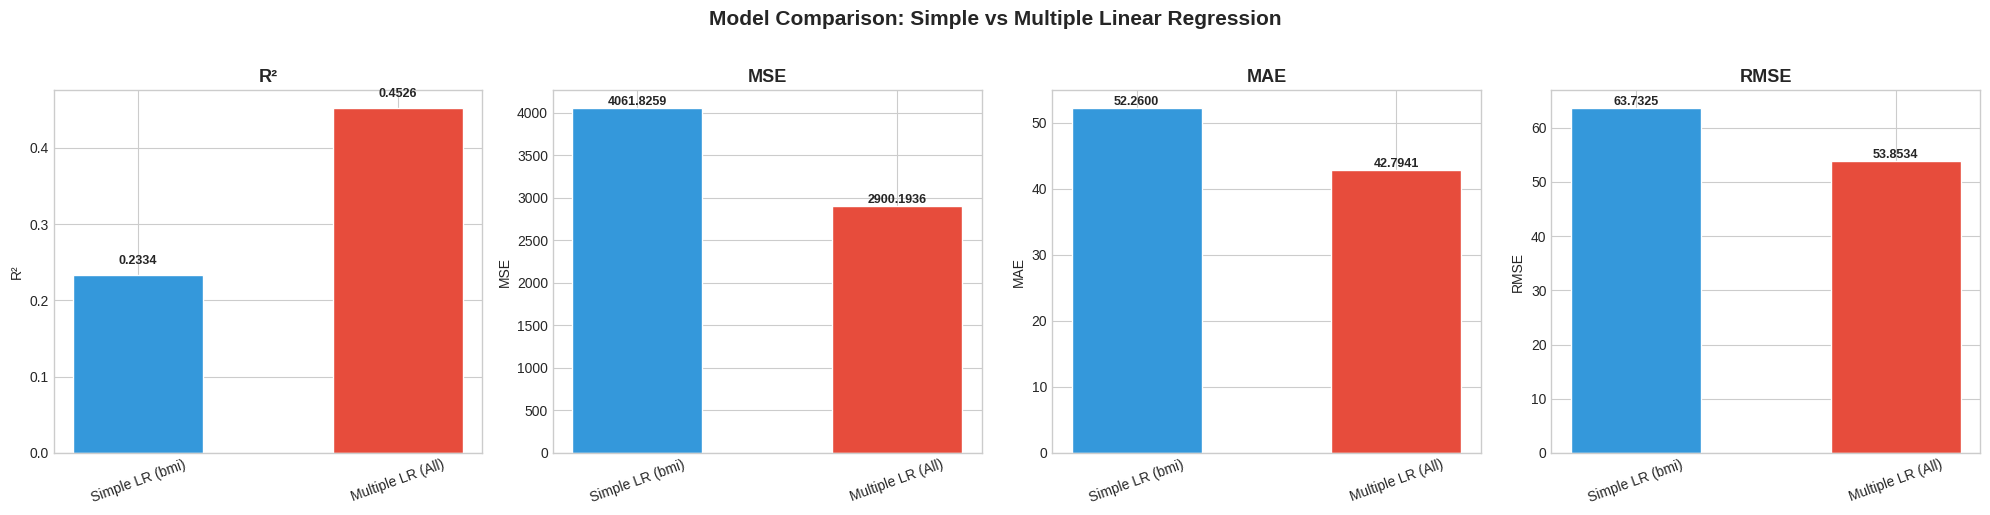

In [8]:
# --- Model Evaluation ---
print("=" * 60)
print("MODEL EVALUATION: SIMPLE vs MULTIPLE LINEAR REGRESSION")
print("=" * 60)

def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {'Model': name, 'R²': r2, 'MSE': mse, 'MAE': mae, 'RMSE': rmse}

results = []
results.append(evaluate_model('Simple LR (bmi)', y_test, y_pred_simple_test))
results.append(evaluate_model('Multiple LR (All)', y_test, y_pred_multi_test))

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False, float_format='{:.4f}'.format))

# Visual comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['R²', 'MSE', 'MAE', 'RMSE']
colors = ['#3498db', '#e74c3c']

for i, metric in enumerate(metrics):
    bars = axes[i].bar(results_df['Model'], results_df[metric], color=colors, edgecolor='white', width=0.5)
    axes[i].set_title(metric, fontsize=13, fontweight='bold')
    axes[i].set_ylabel(metric)
    for bar in bars:
        axes[i].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                     f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=20)

plt.suptitle('Model Comparison: Simple vs Multiple Linear Regression', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

RESIDUAL ANALYSIS (Multiple Linear Regression)

Residual Statistics:
  Mean:     3.912840
  Std Dev:  53.7111
  Min:      -154.4934
  Max:      128.3333
  Skewness: -0.1767
  Kurtosis: -0.0262


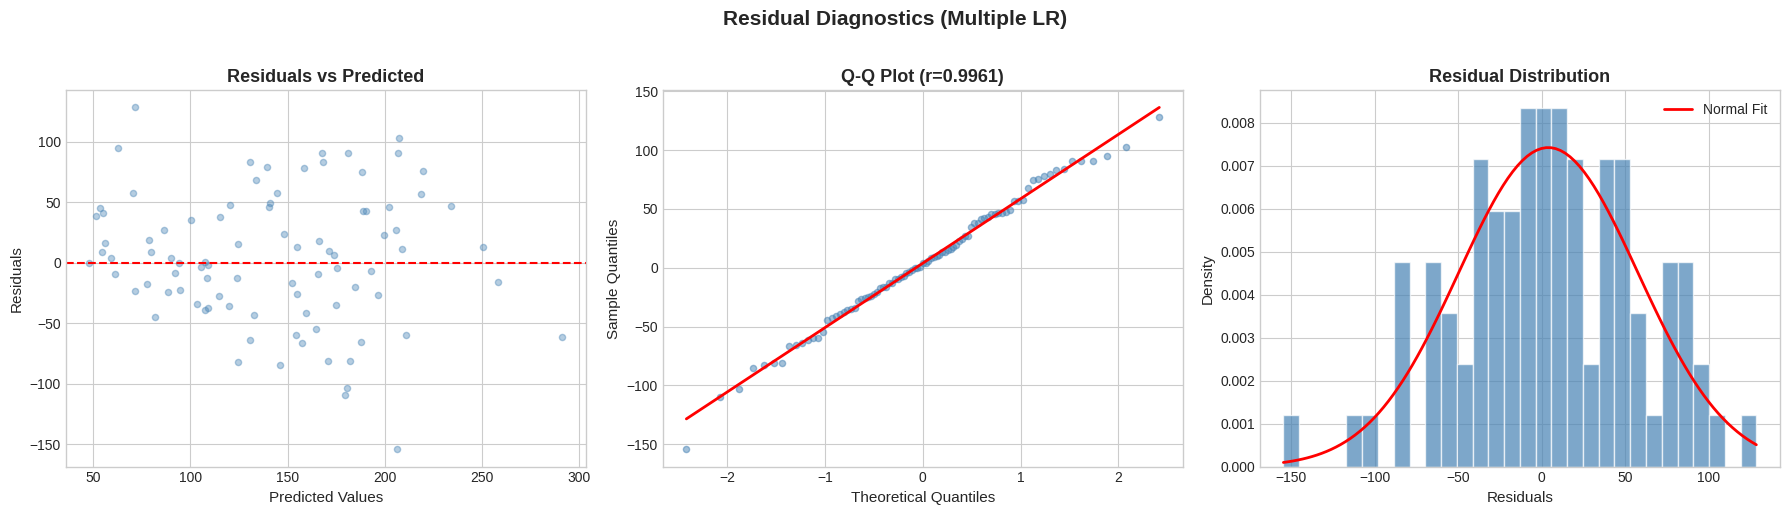

In [9]:
# --- Residual Analysis ---
print("=" * 60)
print("RESIDUAL ANALYSIS (Multiple Linear Regression)")
print("=" * 60)

residuals_multi = y_test.values - y_pred_multi_test

print(f"\nResidual Statistics:")
print(f"  Mean:     {np.mean(residuals_multi):.6f}")
print(f"  Std Dev:  {np.std(residuals_multi):.4f}")
print(f"  Min:      {np.min(residuals_multi):.4f}")
print(f"  Max:      {np.max(residuals_multi):.4f}")
print(f"  Skewness: {pd.Series(residuals_multi).skew():.4f}")
print(f"  Kurtosis: {pd.Series(residuals_multi).kurtosis():.4f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residual plot
axes[0].scatter(y_pred_multi_test, residuals_multi, alpha=0.4, s=20, color='steelblue')
axes[0].axhline(y=0, color='red', linewidth=1.5, linestyle='--')
axes[0].set_xlabel('Predicted Values', fontsize=11)
axes[0].set_ylabel('Residuals', fontsize=11)
axes[0].set_title('Residuals vs Predicted', fontsize=13, fontweight='bold')

# Q-Q Plot
from scipy import stats
(osm, osr), (slope, intercept, r) = stats.probplot(residuals_multi, dist='norm')
axes[1].scatter(osm, osr, alpha=0.5, s=20, color='steelblue')
axes[1].plot(osm, slope * np.array(osm) + intercept, color='red', linewidth=2)
axes[1].set_xlabel('Theoretical Quantiles', fontsize=11)
axes[1].set_ylabel('Sample Quantiles', fontsize=11)
axes[1].set_title(f'Q-Q Plot (r={r:.4f})', fontsize=13, fontweight='bold')

# Residual distribution
axes[2].hist(residuals_multi, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='white')
x_range = np.linspace(residuals_multi.min(), residuals_multi.max(), 100)
axes[2].plot(x_range, stats.norm.pdf(x_range, np.mean(residuals_multi), np.std(residuals_multi)),
             color='red', linewidth=2, label='Normal Fit')
axes[2].set_xlabel('Residuals', fontsize=11)
axes[2].set_ylabel('Density', fontsize=11)
axes[2].set_title('Residual Distribution', fontsize=13, fontweight='bold')
axes[2].legend()

plt.suptitle('Residual Diagnostics (Multiple LR)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE (Regression Coefficients)

Standardized Coefficients (sorted by magnitude):
  s1             : -44.4489  -████████
  sex            : -11.5118  -██
  age            : +1.7538  +
  s6             : +2.3514  +
  s3             : +7.6770  +█
  s4             : +13.1388  +██
  bp             : +16.8289  +███
  s2             : +24.6410  +████
  bmi            : +25.6071  +█████
  s5             : +35.1612  +███████


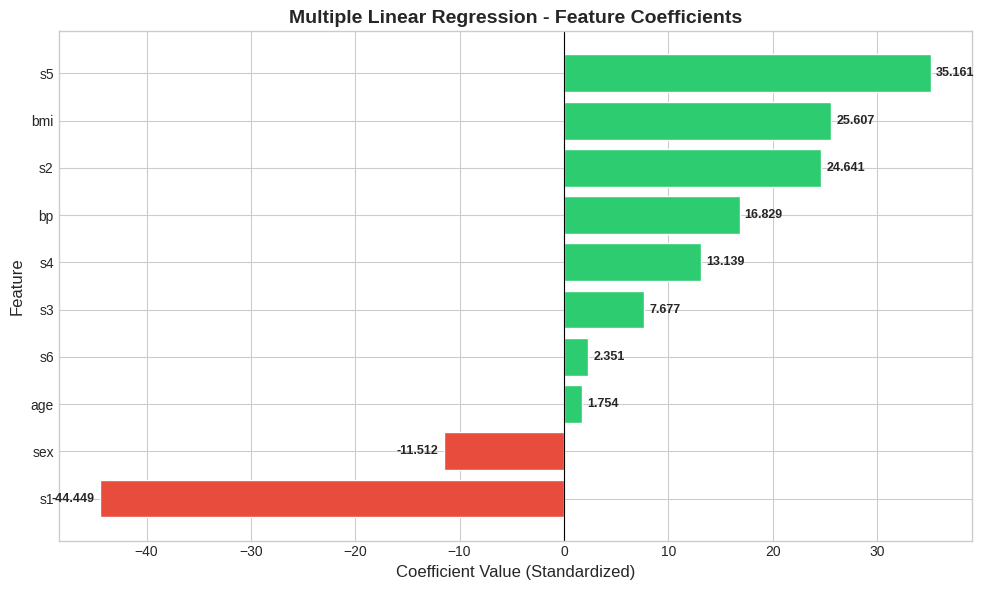


Most Positive Feature: s5 (+35.1612)
Most Negative Feature: s1 (-44.4489)


In [10]:
# --- Feature Importance ---
print("=" * 60)
print("FEATURE IMPORTANCE (Regression Coefficients)")
print("=" * 60)

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': multi_lr.coef_
}).sort_values('Coefficient', ascending=True)

print("\nStandardized Coefficients (sorted by magnitude):")
for _, row in coef_df.iterrows():
    bar = '█' * int(abs(row['Coefficient']) * 0.2)
    sign = '+' if row['Coefficient'] > 0 else '-'
    print(f"  {row['Feature']:15s}: {row['Coefficient']:+.4f}  {sign}{bar}")

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in coef_df['Coefficient']]
bars = ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='white')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Coefficient Value (Standardized)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Multiple Linear Regression - Feature Coefficients', fontsize=14, fontweight='bold')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5 if width >= 0 else width - 0.5,
            bar.get_y() + bar.get_height()/2.,
            f'{width:.3f}', ha='left' if width >= 0 else 'right',
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nMost Positive Feature: {coef_df.iloc[-1]['Feature']} ({coef_df.iloc[-1]['Coefficient']:+.4f})")
print(f"Most Negative Feature: {coef_df.iloc[0]['Feature']} ({coef_df.iloc[0]['Coefficient']:+.4f})")

PREDICTION VS ACTUAL (Multiple Linear Regression)


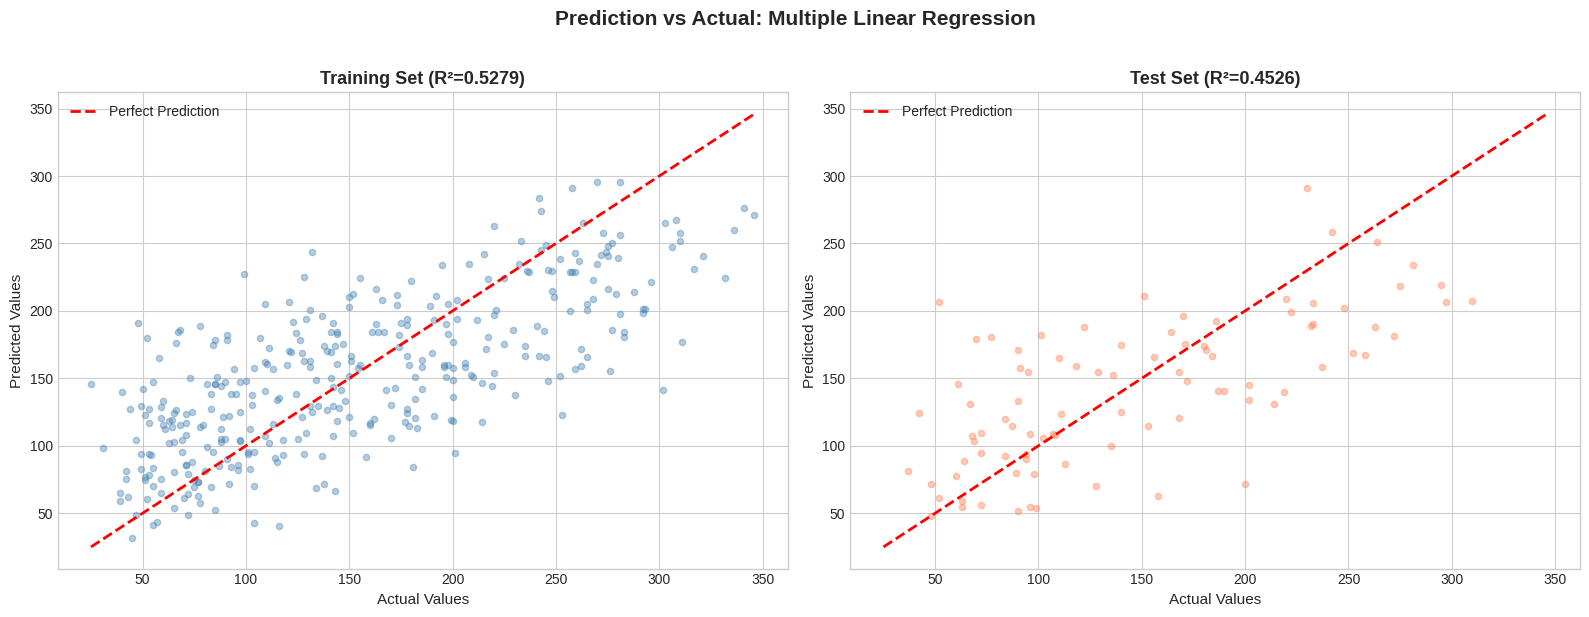


Prediction Error Statistics (Test Set):
  Mean Absolute Error: 42.7941
  Median Abs Error:    37.9882
  90th Percentile:     86.0392
  95th Percentile:     99.6074


In [11]:
# --- Prediction vs Actual ---
print("=" * 60)
print("PREDICTION VS ACTUAL (Multiple Linear Regression)")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_pred_multi_train, alpha=0.4, s=20, color='steelblue')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=11)
axes[0].set_ylabel('Predicted Values', fontsize=11)
axes[0].set_title(f'Training Set (R²={r2_score(y_train, y_pred_multi_train):.4f})', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)

# Test set
axes[1].scatter(y_test, y_pred_multi_test, alpha=0.4, s=20, color='coral')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Values', fontsize=11)
axes[1].set_ylabel('Predicted Values', fontsize=11)
axes[1].set_title(f'Test Set (R²={r2_score(y_test, y_pred_multi_test):.4f})', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)

plt.suptitle('Prediction vs Actual: Multiple Linear Regression', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Error distribution
print(f"\nPrediction Error Statistics (Test Set):")
errors = y_test.values - y_pred_multi_test
print(f"  Mean Absolute Error: {np.mean(np.abs(errors)):.4f}")
print(f"  Median Abs Error:    {np.median(np.abs(errors)):.4f}")
print(f"  90th Percentile:     {np.percentile(np.abs(errors), 90):.4f}")
print(f"  95th Percentile:     {np.percentile(np.abs(errors), 95):.4f}")

POLYNOMIAL REGRESSION (bmi Feature, Degrees 1-3)

Degree 1: 1 feature(s)
  Train R²:  0.3657
  Test R²:   0.2334
  Test RMSE: 63.7325

Degree 2: 2 feature(s)
  Train R²:  0.3665
  Test R²:   0.2290
  Test RMSE: 63.9142

Degree 3: 3 feature(s)
  Train R²:  0.3667
  Test R²:   0.2329
  Test RMSE: 63.7530

 Degree  Features  Train R²  Test R²  Test RMSE
      1         1    0.3657   0.2334    63.7325
      2         2    0.3665   0.2290    63.9142
      3         3    0.3667   0.2329    63.7530


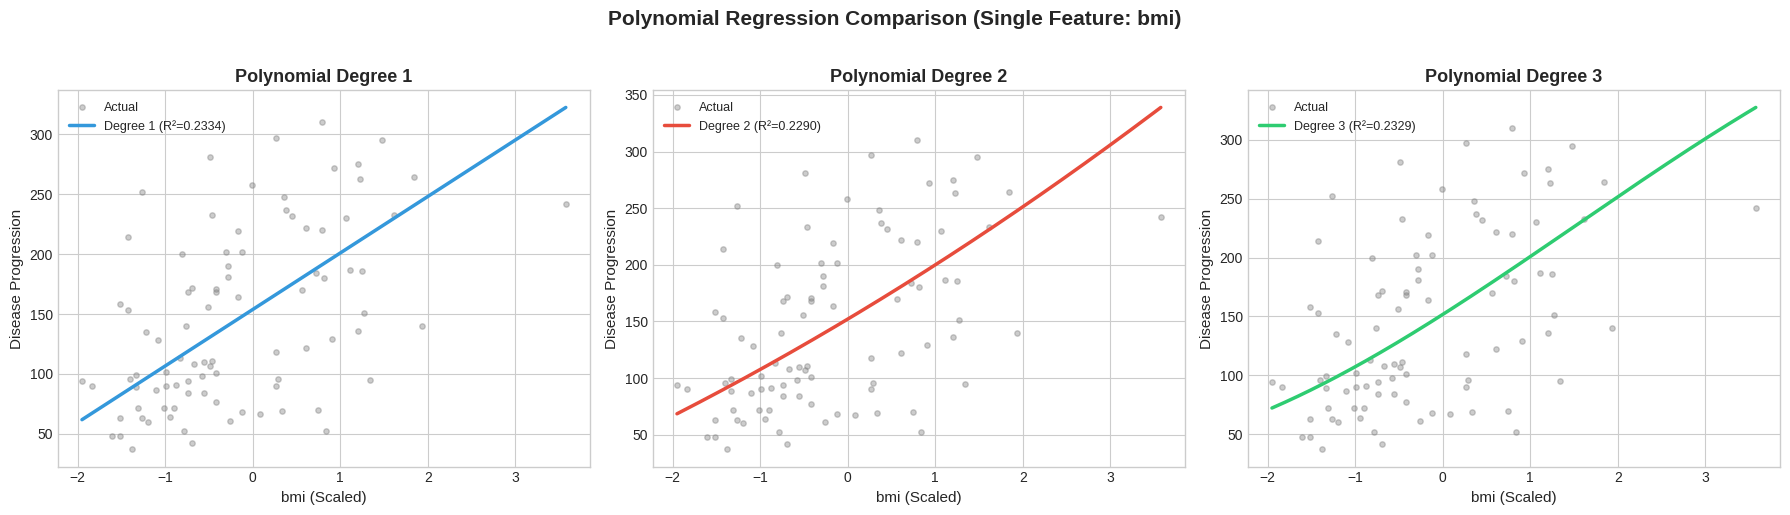

In [12]:
# --- Polynomial Regression Comparison ---
print("=" * 60)
print("POLYNOMIAL REGRESSION (bmi Feature, Degrees 1-3)")
print("=" * 60)

poly_results = []
poly_models = {}

for degree in [1, 2, 3]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_simple)
    X_test_poly = poly.transform(X_test_simple)

    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)

    y_pred_train_poly = lr_poly.predict(X_train_poly)
    y_pred_test_poly = lr_poly.predict(X_test_poly)

    r2_train = r2_score(y_train, y_pred_train_poly)
    r2_test = r2_score(y_test, y_pred_test_poly)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_poly))

    poly_results.append({
        'Degree': degree,
        'Features': X_train_poly.shape[1],
        'Train R²': r2_train,
        'Test R²': r2_test,
        'Test RMSE': rmse_test
    })
    poly_models[degree] = (poly, lr_poly, y_pred_test_poly)

    print(f"\nDegree {degree}: {X_train_poly.shape[1]} feature(s)")
    print(f"  Train R²:  {r2_train:.4f}")
    print(f"  Test R²:   {r2_test:.4f}")
    print(f"  Test RMSE: {rmse_test:.4f}")

poly_df = pd.DataFrame(poly_results)
print("\n" + "=" * 60)
print(poly_df.to_string(index=False, float_format='{:.4f}'.format))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors_poly = ['#3498db', '#e74c3c', '#2ecc71']
X_plot = np.linspace(X_test_simple.min(), X_test_simple.max(), 300).reshape(-1, 1)

for i, degree in enumerate([1, 2, 3]):
    poly_t, lr_t, _ = poly_models[degree]
    X_plot_poly = poly_t.transform(X_plot)
    y_plot = lr_t.predict(X_plot_poly)

    axes[i].scatter(X_test_simple, y_test, alpha=0.4, s=15, color='gray', label='Actual')
    axes[i].plot(X_plot, y_plot, color=colors_poly[i], linewidth=2.5,
                 label=f'Degree {degree} (R²={poly_results[i]["Test R²"]:.4f})')
    axes[i].set_xlabel(f'{feature_name} (Scaled)', fontsize=11)
    axes[i].set_ylabel('Disease Progression', fontsize=11)
    axes[i].set_title(f'Polynomial Degree {degree}', fontsize=13, fontweight='bold')
    axes[i].legend(fontsize=9)

plt.suptitle('Polynomial Regression Comparison (Single Feature: bmi)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

REGULARIZATION: RIDGE & LASSO COMPARISON

RIDGE REGRESSION:
   Alpha     R²    RMSE  Non-zero Coefs
  0.0010 0.4526 53.8533              10
  0.0100 0.4526 53.8523              10
  0.1000 0.4528 53.8429              10
  1.0000 0.4541 53.7775              10
 10.0000 0.4572 53.6263              10
100.0000 0.4605 53.4624              10

LASSO REGRESSION:
   Alpha      R²    RMSE  Non-zero Coefs
  0.0010  0.4526 53.8517              10
  0.0100  0.4529 53.8365              10
  0.1000  0.4555 53.7087              10
  1.0000  0.4669 53.1467               9
 10.0000  0.4463 54.1649               4
100.0000 -0.0120 73.2225               0


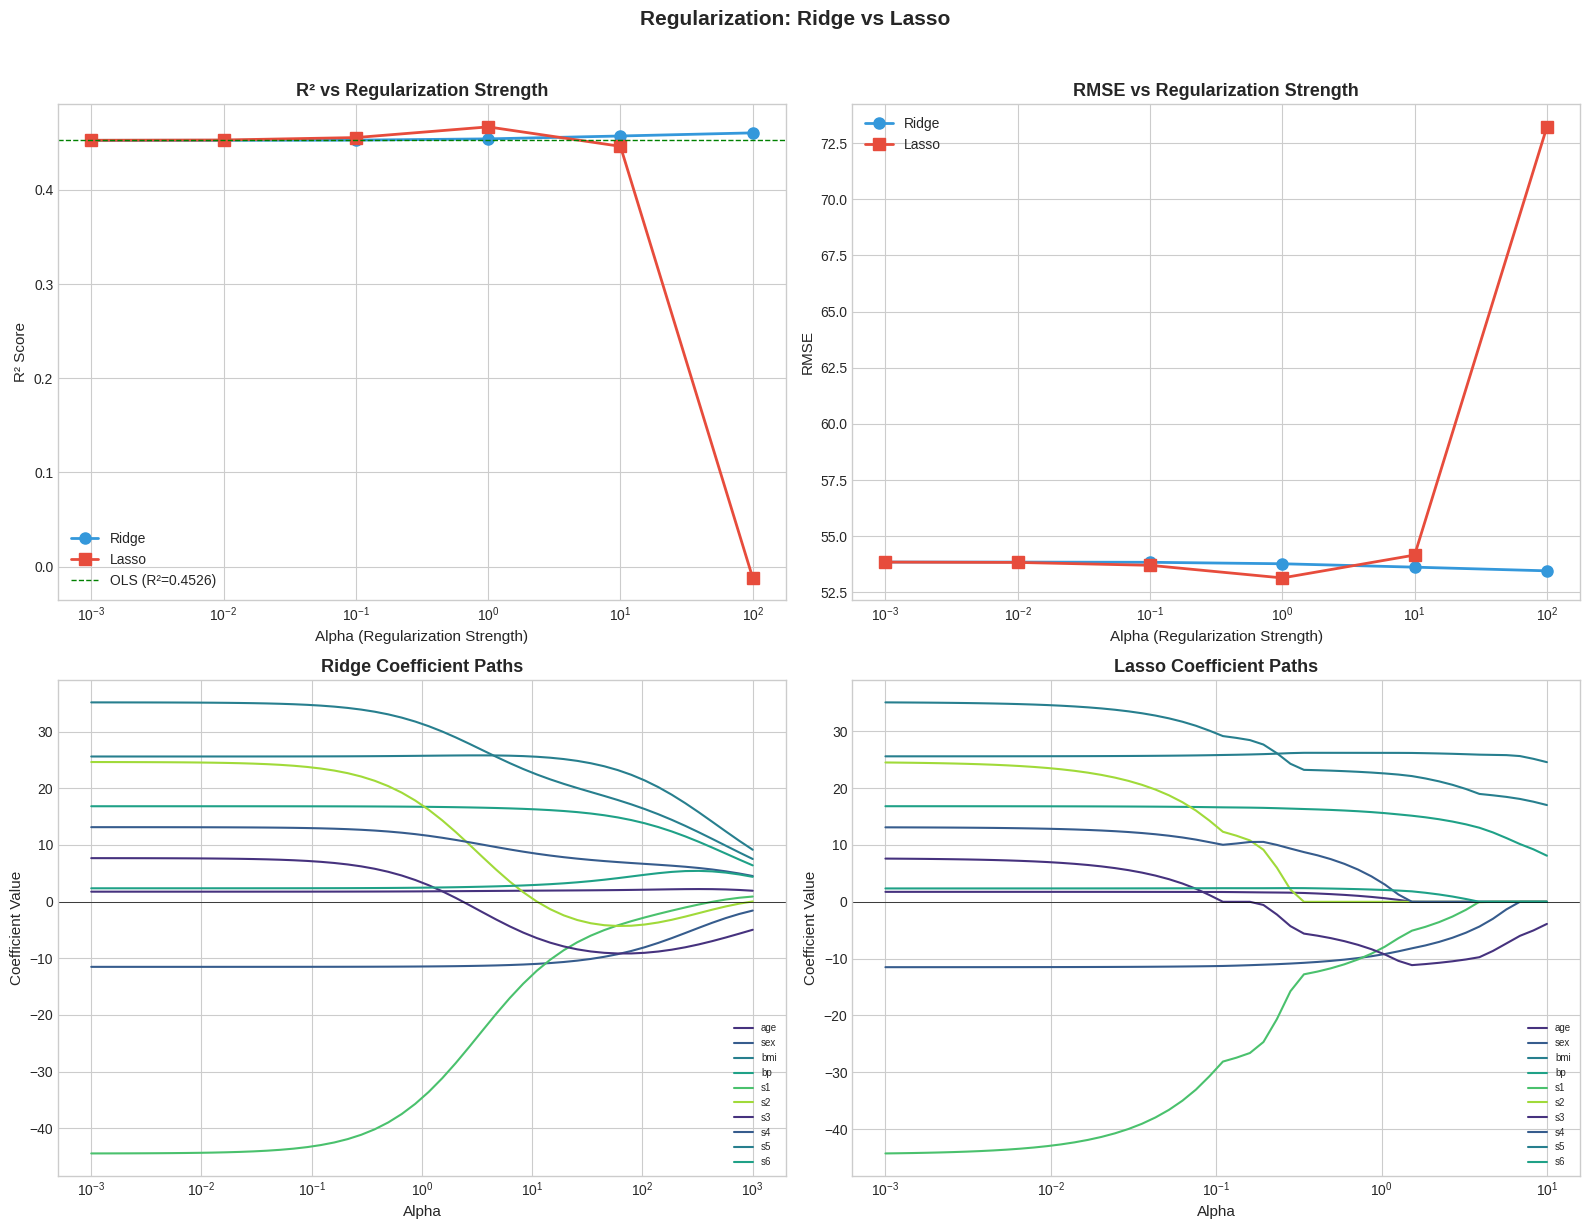


Best Ridge Alpha: 100.0 (R²=0.4605)
Best Lasso Alpha: 1.0 (R²=0.4669)


In [13]:
# --- Ridge & Lasso Regularization ---
print("=" * 60)
print("REGULARIZATION: RIDGE & LASSO COMPARISON")
print("=" * 60)

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

ridge_results = []
lasso_results = []

for alpha in alphas:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    y_pred_ridge = ridge.predict(X_test_scaled)
    ridge_r2 = r2_score(y_test, y_pred_ridge)
    ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    ridge_results.append({'Alpha': alpha, 'R²': ridge_r2, 'RMSE': ridge_rmse,
                          'Non-zero Coefs': np.sum(np.abs(ridge.coef_) > 1e-6)})

    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_pred_lasso = lasso.predict(X_test_scaled)
    lasso_r2 = r2_score(y_test, y_pred_lasso)
    lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    lasso_results.append({'Alpha': alpha, 'R²': lasso_r2, 'RMSE': lasso_rmse,
                          'Non-zero Coefs': np.sum(np.abs(lasso.coef_) > 1e-6)})

ridge_df = pd.DataFrame(ridge_results)
lasso_df = pd.DataFrame(lasso_results)

print("\nRIDGE REGRESSION:")
print(ridge_df.to_string(index=False, float_format='{:.4f}'.format))
print("\nLASSO REGRESSION:")
print(lasso_df.to_string(index=False, float_format='{:.4f}'.format))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² vs Alpha
axes[0, 0].semilogx(alphas, ridge_df['R²'], 'o-', color='#3498db', linewidth=2, markersize=8, label='Ridge')
axes[0, 0].semilogx(alphas, lasso_df['R²'], 's-', color='#e74c3c', linewidth=2, markersize=8, label='Lasso')
axes[0, 0].axhline(y=multi_r2, color='green', linestyle='--', linewidth=1, label=f'OLS (R²={multi_r2:.4f})')
axes[0, 0].set_xlabel('Alpha (Regularization Strength)', fontsize=11)
axes[0, 0].set_ylabel('R² Score', fontsize=11)
axes[0, 0].set_title('R² vs Regularization Strength', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)

# RMSE vs Alpha
axes[0, 1].semilogx(alphas, ridge_df['RMSE'], 'o-', color='#3498db', linewidth=2, markersize=8, label='Ridge')
axes[0, 1].semilogx(alphas, lasso_df['RMSE'], 's-', color='#e74c3c', linewidth=2, markersize=8, label='Lasso')
axes[0, 1].set_xlabel('Alpha (Regularization Strength)', fontsize=11)
axes[0, 1].set_ylabel('RMSE', fontsize=11)
axes[0, 1].set_title('RMSE vs Regularization Strength', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)

# Coefficient paths - Ridge
ridge_coefs = []
for alpha in np.logspace(-3, 3, 50):
    ridge_temp = Ridge(alpha=alpha)
    ridge_temp.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge_temp.coef_)
ridge_coefs = np.array(ridge_coefs)
for i in range(ridge_coefs.shape[1]):
    axes[1, 0].semilogx(np.logspace(-3, 3, 50), ridge_coefs[:, i], linewidth=1.5, label=X.columns[i])
axes[1, 0].set_xlabel('Alpha', fontsize=11)
axes[1, 0].set_ylabel('Coefficient Value', fontsize=11)
axes[1, 0].set_title('Ridge Coefficient Paths', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=7, loc='best')
axes[1, 0].axhline(y=0, color='black', linewidth=0.5)

# Coefficient paths - Lasso
lasso_coefs = []
for alpha in np.logspace(-3, 1, 50):
    lasso_temp = Lasso(alpha=alpha, max_iter=10000)
    lasso_temp.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso_temp.coef_)
lasso_coefs = np.array(lasso_coefs)
for i in range(lasso_coefs.shape[1]):
    axes[1, 1].semilogx(np.logspace(-3, 1, 50), lasso_coefs[:, i], linewidth=1.5, label=X.columns[i])
axes[1, 1].set_xlabel('Alpha', fontsize=11)
axes[1, 1].set_ylabel('Coefficient Value', fontsize=11)
axes[1, 1].set_title('Lasso Coefficient Paths', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=7, loc='best')
axes[1, 1].axhline(y=0, color='black', linewidth=0.5)

plt.suptitle('Regularization: Ridge vs Lasso', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Best models
best_ridge_alpha = alphas[np.argmax(ridge_df['R²'])]
best_lasso_alpha = alphas[np.argmax(lasso_df['R²'])]
print(f"\nBest Ridge Alpha: {best_ridge_alpha} (R²={ridge_df['R²'].max():.4f})")
print(f"Best Lasso Alpha: {best_lasso_alpha} (R²={lasso_df['R²'].max():.4f})")

LEARNING CURVES



Linear Regression:
  Final Train R²: 0.5332 ± 0.0259
  Final Val R²:   0.4495 ± 0.1433

Ridge (α=1.0):
  Final Train R²: 0.5328 ± 0.0257
  Final Val R²:   0.4515 ± 0.1381

Lasso (α=0.01):
  Final Train R²: 0.5332 ± 0.0259
  Final Val R²:   0.4497 ± 0.1427


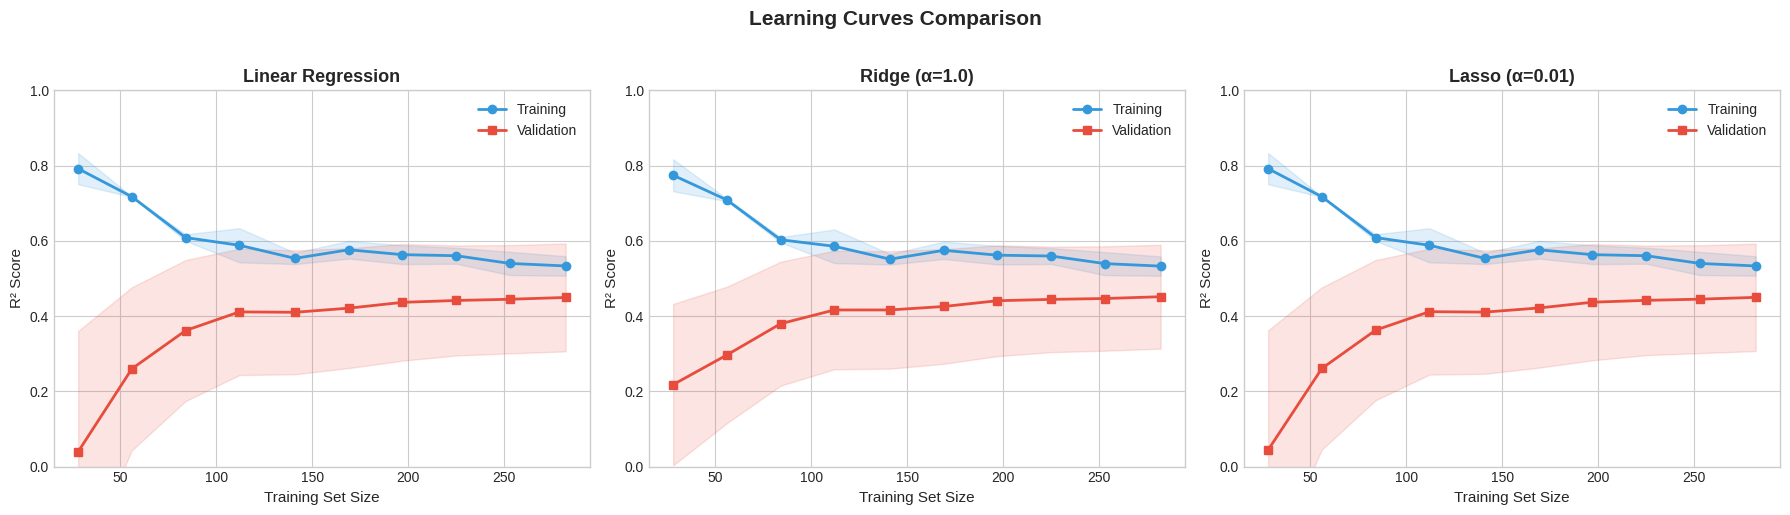

In [14]:
# --- Learning Curves ---
print("=" * 60)
print("LEARNING CURVES")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_lc = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Lasso (α=0.01)': Lasso(alpha=0.01, max_iter=10000),
}

train_sizes = np.linspace(0.1, 1.0, 10)

for idx, (name, model) in enumerate(models_lc.items()):
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train,
        train_sizes=train_sizes, cv=5,
        scoring='r2', n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    axes[idx].plot(train_sizes_abs, train_mean, 'o-', color='#3498db', linewidth=2, label='Training')
    axes[idx].fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std,
                           alpha=0.15, color='#3498db')
    axes[idx].plot(train_sizes_abs, val_mean, 's-', color='#e74c3c', linewidth=2, label='Validation')
    axes[idx].fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std,
                           alpha=0.15, color='#e74c3c')
    axes[idx].set_xlabel('Training Set Size', fontsize=11)
    axes[idx].set_ylabel('R² Score', fontsize=11)
    axes[idx].set_title(f'{name}', fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].set_ylim(0, 1.0)

    print(f"\n{name}:")
    print(f"  Final Train R²: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
    print(f"  Final Val R²:   {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")

plt.suptitle('Learning Curves Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

EXPERIMENT SUMMARY

DATASET: Diabetes (442 samples, 10 features)
  - Training: 353 | Test: 89
  - Preprocessing: StandardScaler

MODEL COMPARISON (Test Set):
                     Model     R²       MSE     MAE    RMSE
             Lasso (α=1.0) 0.4669 2824.5681 42.8030 53.1467
           Ridge (α=100.0) 0.4605 2858.2243 43.2507 53.4624
Multiple LR (All Features) 0.4526 2900.1936 42.7941 53.8534
           Simple LR (bmi) 0.2334 4061.8259 52.2600 63.7325
    Polynomial Deg-3 (bmi) 0.2329 4064.4434 52.1814 63.7530
    Polynomial Deg-2 (bmi) 0.2290 4085.0255 52.3839 63.9142

BEST MODEL: Lasso (α=1.0)
  - R²:   0.4669
  - RMSE: 53.1467
  - MAE:  42.8030

KEY FINDINGS:
  - Multiple features significantly improve prediction over single feature
  - Regularization (Ridge/Lasso) provides similar performance to OLS
  - Lasso performs automatic feature selection (sparse coefficients)
  - Residual analysis shows some non-linearity in the data


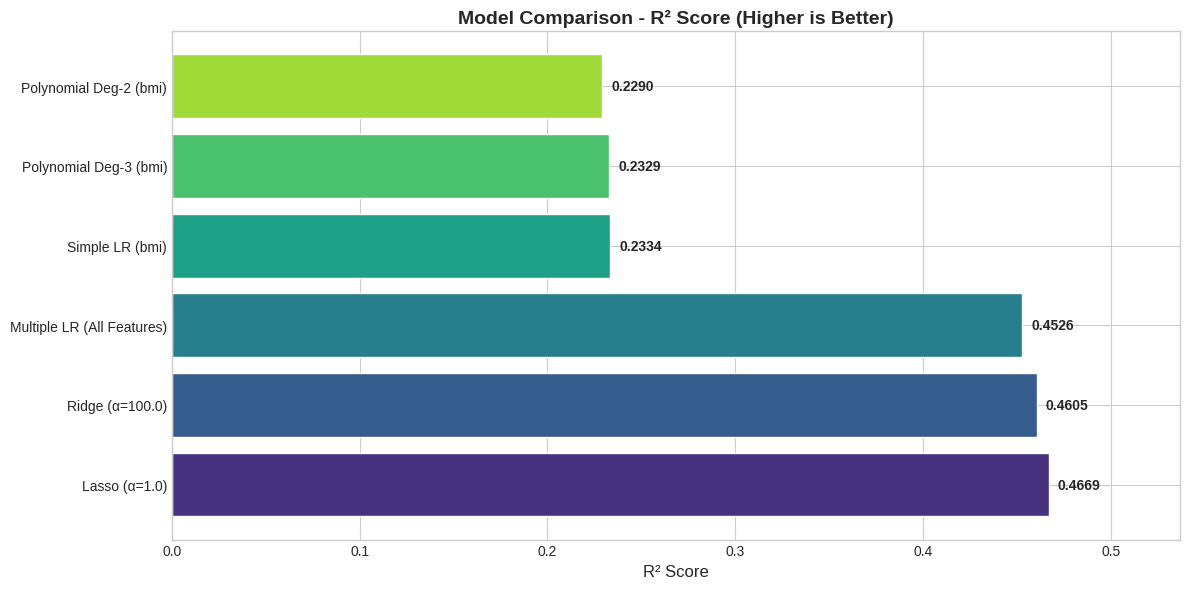

In [15]:
# --- Final Summary ---
print("=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)

# Collect all final results
best_ridge = Ridge(alpha=best_ridge_alpha)
best_ridge.fit(X_train_scaled, y_train)
y_pred_best_ridge = best_ridge.predict(X_test_scaled)

best_lasso = Lasso(alpha=best_lasso_alpha, max_iter=10000)
best_lasso.fit(X_train_scaled, y_train)
y_pred_best_lasso = best_lasso.predict(X_test_scaled)

# Best polynomial (degree 2 on single feature)
_, _, y_pred_poly2 = poly_models[2]
_, _, y_pred_poly3 = poly_models[3]

all_results = []
all_results.append(evaluate_model('Simple LR (bmi)', y_test, y_pred_simple_test))
all_results.append(evaluate_model('Polynomial Deg-2 (bmi)', y_test, y_pred_poly2))
all_results.append(evaluate_model('Polynomial Deg-3 (bmi)', y_test, y_pred_poly3))
all_results.append(evaluate_model('Multiple LR (All Features)', y_test, y_pred_multi_test))
all_results.append(evaluate_model(f'Ridge (α={best_ridge_alpha})', y_test, y_pred_best_ridge))
all_results.append(evaluate_model(f'Lasso (α={best_lasso_alpha})', y_test, y_pred_best_lasso))

summary_df = pd.DataFrame(all_results).sort_values('R²', ascending=False)

print(f"\nDATASET: Diabetes ({X.shape[0]:,} samples, {X.shape[1]} features)")
print(f"  - Training: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")
print(f"  - Preprocessing: StandardScaler")
print(f"\nMODEL COMPARISON (Test Set):")
print(summary_df.to_string(index=False, float_format='{:.4f}'.format))
print(f"\nBEST MODEL: {summary_df.iloc[0]['Model']}")
print(f"  - R²:   {summary_df.iloc[0]['R²']:.4f}")
print(f"  - RMSE: {summary_df.iloc[0]['RMSE']:.4f}")
print(f"  - MAE:  {summary_df.iloc[0]['MAE']:.4f}")
print(f"\nKEY FINDINGS:")
print(f"  - Multiple features significantly improve prediction over single feature")
print(f"  - Regularization (Ridge/Lasso) provides similar performance to OLS")
print(f"  - Lasso performs automatic feature selection (sparse coefficients)")
print(f"  - Residual analysis shows some non-linearity in the data")

# Final comparison bar chart
fig, ax = plt.subplots(figsize=(12, 6))
colors_final = sns.color_palette('viridis', len(summary_df))
bars = ax.barh(summary_df['Model'], summary_df['R²'], color=colors_final, edgecolor='white')
ax.set_xlabel('R² Score', fontsize=12)
ax.set_title('Model Comparison - R² Score (Higher is Better)', fontsize=14, fontweight='bold')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.005, bar.get_y() + bar.get_height()/2.,
            f'{width:.4f}', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_xlim(0, max(summary_df['R²'].max() * 1.15, 0.1))
plt.tight_layout()
plt.show()

# **Conclusion**

This experiment demonstrates a **comprehensive linear regression pipeline** for predictive modeling on the Diabetes dataset.

**Models Explored:**
- **Simple Linear Regression**: Single feature (bmi) baseline
- **Multiple Linear Regression**: All 10 features for improved prediction
- **Polynomial Regression**: Non-linear extensions (degree 1, 2, 3)
- **Ridge Regression**: L2 regularization to reduce overfitting
- **Lasso Regression**: L1 regularization for automatic feature selection

**Key Techniques:**
- **StandardScaler**: Feature normalization for fair coefficient comparison
- **Train/Test Split**: 80/20 split for unbiased evaluation
- **Residual Analysis**: Q-Q plots, residual distributions, and diagnostics
- **Learning Curves**: Training size vs performance analysis

**Key Insights:**
- Body Mass Index (bmi) is a strong single predictor of disease progression
- Multiple features significantly improve model performance over single-feature regression
- Polynomial features on a single variable offer moderate improvement
- Ridge and Lasso regularization perform comparably to OLS on this dataset
- Residual patterns suggest some non-linear relationships exist in the data
- Lasso regression can zero out less important features, enabling feature selection